# Lab 7: Convolutional Autoencoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this lab, we will be introducing and getting familiar with the concept of convolutional autoencoders.

**Make sure to get all checkpoints checked off by your TA to get credit for this lab!**

## Introduction
Autoencoders are really cool. They use this architecture of encoder + decoder to learn data representation in an unsupervised manner. Sounds complicated? Let's break it down.

![Autoencoders](https://drive.google.com/uc?export=view&id=18iU9_yZfqs2QlTPbaibzkMtdIekLuPj2)

As we can see, the autoencoder is divided roughly in two parts:
- The **encoder** that encodes the input to a "code" (internal representation) with reduced dimensions.
- The **decoder** that decodes the "code" to an output that is the same dimensions as the input.

The autoencoder tries to learn a function $h(x) \approx x$, or to approximate the identity function to output $h(x) = x'$ that is similar to $x$.

This may sound like a pretty trivial task, so why not just use the identity function? Well, it's impossible to find a perfect representation of the identity function since we reduced dimensionality of the input into the code during the encoding part, and try to "reconstruct" the original image using only the dimensionally reduced code.

E.x. Given an input of a 10x10 image, and a hidden size of 50, the encoder is forced to learn a compressed representation of the image (from 100 units to 50 units). This encoding is almost always lossy, but the point is that we train the encoder to recognize important structures in the input and throw away the unimportant noise.

### In this lab, we will do the following:
 - Discuss inverse convolutions.
 - Make a simple autoencoding structure.
 - Implement a denoising autoencoder to denoise MNIST digits.

## Transposed-Convolution
Conceptually, transposed-convolution reverses the effects of convolution. Convolution with a stride of larger than 1 reduces the size of the input, while transposed-convolution can be described as a "fractional stride" convolution, it upscales the size of the input. Here's a visualisation.

#### Convolution with stride = 2 *going from bigger to smaller*:
![convolution.gif](https://drive.google.com/uc?export=view&id=1TjSgMinNQ629TrdEmcVjKuwWZ9MGMfg7)

#### Transposed-Convolution (convolution with fractional stride) *going from smaller to bigger*:
![deconvolution.gif](https://drive.google.com/uc?export=view&id=1opzIaiShA5_nLT5Y5Kh_GqPT9IlVeQF5)

As we can see, transposed-convolution upscales the input. This is important for our decoder as its job is to upscale the encoded and compressed internal representation to its original size.

You can perform the manual transpose-convolution operation using the [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose) method, but you may feel free to use the [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layer method, which is similar to the Conv2D method introduced earlier.

## [Check-off]

- Though this is an inverse operation, it still gets optimized all the same, right? So, what do you expect is the desired utility of the transpose convolution operation?

- How much of the input data is accessible for the decision process of a given output region? Do you think this could have any downstream effects when the autoencoder is does not go down to a 1x1 pixel space?

## Setup

Enabling the GPU:

- Navigate to `Edit → Notebook Settings`
- Set `Hardware Accelerator: GPU`

In [ ]:
import tensorflow as tf
import numpy as np
import IPython.display  ## For displaying images/gifs generated in your lab

print('Tensorflow Version:', tf.__version__)
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

Tensorflow Version: 2.15.0
Num GPUs Available: 1


***Please verify that you have a GPU available.***

# Getting A Working Autoencoder

First Off, let's just get a basic autoencoder up and running that reconstructs data through a deep bottleneck.


### MNIST Data

For our simple example, we are going to load in the MNIST data once again!

**NOTES:**
- Since the dataset is so big, we will just discard the formal training set and will just use a subset of the testing set.

- We will resize all of the images to be (32x32) just because it's an easy power of 2 (you'll see why in a second). This can still work with non-powers-of-2, but you have to do some annoying resizing, reshaping, parameter tuning, or other stuff. This just makes life easier.

- We won't really be using the labels in the optimization pipeline, so we don't need to one-hot encode them.

In [ ]:
# Loading in and preprocessing the data *the manual way* because why not...
mnist = tf.keras.datasets.mnist
(X0, L0), (_, _) = mnist.load_data()
X0 = tf.cast(X0, tf.float32) / 255.0
X0 = tf.expand_dims(X0, -1)
X0 = tf.image.resize(X0, [32,32])

print(f'X0 = {X0.shape, X0.dtype}')
print(f'Y0 = {L0.shape, L0.dtype}')

11490434/11490434 [==============================] - 0s 0us/step
X0 = (TensorShape([60000, 32, 32, 1]), tf.float32)
Y0 = ((60000,), dtype('uint8'))


### Implementing The Auto-Encoder

Below, we are going to ask for you to go ahead and implement the autoencoder.

The basic structure of an auto-encoder has already been discussed previously and shouldn't come as a surprise:

Learn a hypothesis function $h(x) = h_{decoder}(h_{encoder}(x))$ such that $h(x) \sim x$.

Below, go ahead and finish the autoencoder implementation.

- Implement the autoencoder `call()` function.

- Implement the encoder and decoder architectures with a nice bottleneck.

**NOTES:**
- Consider what is reasonable for the encoder/decoder layers. We're going from a 32x32 one-channel input to a latent encoding and then back, so maybe extreme values in the 100s might not be useful channel specifications.

- Note that your input and output dimensions must match. To make this easy, the MNIST digits are already powers of 2, so... do with that info what you will (something something strides)!  

- Some of the arguments are already given to you in the `conv_kwargs` dictionary, so consider using them to make your code shorter.
   - Recall that `f(**{'n' : 2})` and `f(n=2)` are equivalent...

- Later on, you'll be seeing the first channel of the encoding layer (upsampled to a 32x32 space). So depending on what your embedding ends up, you might not see much. That's totally fine, though!

- If you are confused on the general architecture of the encoder and decoder, review the lecture slides on autoencoders. Keep in mind the sizes/desired shapes at each step of the encoder and decoder. Any connection between them?

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

class Autoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        res = self.decoder(self.encoder(inputs))
        return res

## Some common keyword arguments you way want to use. HINT: func(**kwargs)
conv_kwargs = {
    "padding"             : "SAME",
    "activation"          : tf.keras.layers.LeakyReLU(alpha=0.2),
    "kernel_initializer"  : tf.random_normal_initializer(stddev=.1)
}

## TODO: Make encoder and decoder sub-models
ae_model = Autoencoder(
    encoder = tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), strides=2, **conv_kwargs),
        Conv2D(filters=64, kernel_size=(3, 3), strides=2, **conv_kwargs),
        Conv2D(filters=128, kernel_size=(3, 3), strides=2, **conv_kwargs),
    ], name="ae_encoder"),
    decoder = tf.keras.Sequential([
        Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, **conv_kwargs),
        Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, **conv_kwargs),
        Conv2DTranspose(filters=1, kernel_size=(3,3), strides=2, **conv_kwargs)
    ], name='ae_decoder')
, name='autoencoder')

ae_model.build(input_shape = X0.shape)   ## Required to see architecture summary
initial_weights = ae_model.get_weights() ## Just so we can reset out autoencoder

ae_model.summary()
ae_model.encoder.summary()
ae_model.decoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_encoder (Sequential)     (60000, 4, 4, 128)        92672     
                                                                 
 ae_decoder (Sequential)     (60000, 32, 32, 1)        92545     
                                                                 
Total params: 185217 (723.50 KB)
Trainable params: 185217 (723.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "ae_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (60000, 16, 16, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (60000, 8, 8, 64)         18496     
                                                             

### Making A Visualization Routine

We'd like to go ahead and see how the training is going, right? We can do this using something called a **callback function**.

In general terms, a callback function is a function that executes throughout a pipeline or routine. You may be familiar with the keystroke callback in a general event loop, where you specify what keys you want to check for (i.e. the 'q' key to quit your program) and then the loop will execute your routine (i.e. quit the program) when it checks for user input.

Keras also has this, and we can make our own callbacks pretty easy. The below code uses some visualization code to construct a gif image and accumulates frames on each epoch's end by overriding the `on_epoch_end` method. For more information on this, feel free to check out the [Keras custom callback documantation](https://www.tensorflow.org/guide/keras/custom_callback).

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image   ## Python Image Library. Very Useful
import io

class ImageVisualizer(tf.keras.callbacks.Callback):
    def __init__(self, model, sample_inputs, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.sample_inputs = sample_inputs
        self.imgs = []

    def on_epoch_end(self, epoch, logs=None):
        encoding   = self.model.encoder(self.sample_inputs)
        prediction = self.model.decoder(encoding)  ## = self.model(self.sample_inputs)
        enc_pic = tf.image.resize(encoding, [32, 32], method=tf.image.ResizeMethod.MITCHELLCUBIC)

        self.add_to_imgs(
            tf.concat([
                self.sample_inputs,
                enc_pic[:,:,:,:1],
                prediction
            ], axis=0),
            epoch = epoch
        )

    def add_to_imgs(self, outputs, epoch, nrows=3, ncols=8, figsize=(18, 8)):
        '''
        Plot the image samples in outputs in a pyplot figure and add the image
        to the 'imgs' list. Used to later generate a gif.
        '''
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        axs[0][0].set_title(f'Epoch {epoch+1}')
        axs[0][3].set_title('Inputs')
        axs[1][3].set_title('Encoding')
        axs[1][4].set_title('(Channel 0, upscaled)')
        axs[2][3].set_title('Decoding')
        for i, ax in enumerate(axs.reshape(-1)):
            out_numpy = np.squeeze(outputs[i].numpy(), -1)
            ax.imshow(out_numpy, cmap='gray')
        self.imgs += [self.fig2img(fig)]
        plt.close(fig)

    @staticmethod
    def fig2img(fig):
        """
        Convert a Matplotlib figure to a PIL Image and return it
        https://stackoverflow.com/a/61754995/5003309
        """
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        return Image.open(buf)

    def save_gif(self, filename='mnist_recon', loop=True, duration=500):
        imgs = self.imgs
        self.imgs[0].save(
            filename+'.gif', save_all=True, append_images=self.imgs[1:],
            loop=loop, duration=duration)

### Actually Training The Model!

Finally, it's time to actually train the model! Hurray!

To optimize our architecture, we could use [mean squared error](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) like before, right? OR maybe we could use [binary cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy). There might actually be merit to both though...

Why don't you try implementing a combination of both!

**NOTES:**
 - There are many ways of implementing a custom loss function, which include:
   - Implementing a [custom loss function](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss) from scratch.

     - You can create a true keras loss function or just a simple custom one will also work.

   - Taking several loss functions and combining them by redirecting the loss arguments into both of them.
     - If you do that, consider using `def mse_bce_loss(*args, **kwargs)` to capture all of the positional and keyword arguments.

 - You will have to balance the loss functions with a scaling term. Consider the evaluation metrics and think about what would be a good equalizing scaler.

 - You may have to tune the learning rate!

In [ ]:
## Callback function: Visualized the last 8 images in dataset (which are never trained on)
imgviz_callback = ImageVisualizer(ae_model, X0[-8:])

ae_model.set_weights(initial_weights)  ## Resets model weights.


# mse_loss = tf.keras.losses.MeanSquaredError()     ## HINTS
# bce_loss = tf.keras.losses.BinaryCrossentropy()

## TODO: Implement mse_bce_loss and figure out an appropriate balance scale
def mse_bce_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return mse + 0.8 * bce  # you can adjust the balance between mse and bce by multiplying them with a constant
# mse_bce_loss = tf.identity

ae_model.compile(
    optimizer   = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss        = mse_bce_loss,
    metrics     = [
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.BinaryCrossentropy()
    ]
)

ae_model.fit(
    X0[:5000], X0[:5000],
    epochs     = 10,
    batch_size = 20,
    validation_data = (X0[5000:6000], X0[5000:6000]),
    callbacks  = [imgviz_callback]
);

Epoch 1/10
250/250 [==============================] - 4s 10ms/step - loss: 0.1830 - mean_squared_error: 0.0239 - binary_crossentropy: 0.1989 - val_loss: 0.1136 - val_mean_squared_error: 0.0096 - val_binary_crossentropy: 0.1300
Epoch 2/10
250/250 [==============================] - 3s 11ms/step - loss: 0.1064 - mean_squared_error: 0.0078 - binary_crossentropy: 0.1233 - val_loss: 0.0999 - val_mean_squared_error: 0.0055 - val_binary_crossentropy: 0.1180
Epoch 3/10
250/250 [==============================] - 2s 9ms/step - loss: 0.1128 - mean_squared_error: 0.0089 - binary_crossentropy: 0.1299 - val_loss: 0.1066 - val_mean_squared_error: 0.0076 - val_binary_crossentropy: 0.1238
Epoch 4/10
250/250 [==============================] - 3s 11ms/step - loss: 0.0991 - mean_squared_error: 0.0056 - binary_crossentropy: 0.1169 - val_loss: 0.0970 - val_mean_squared_error: 0.0046 - val_binary_crossentropy: 0.1155
Epoch 5/10
250/250 [==============================] - 3s 11ms/step - loss: 0.1117 - mean_squa

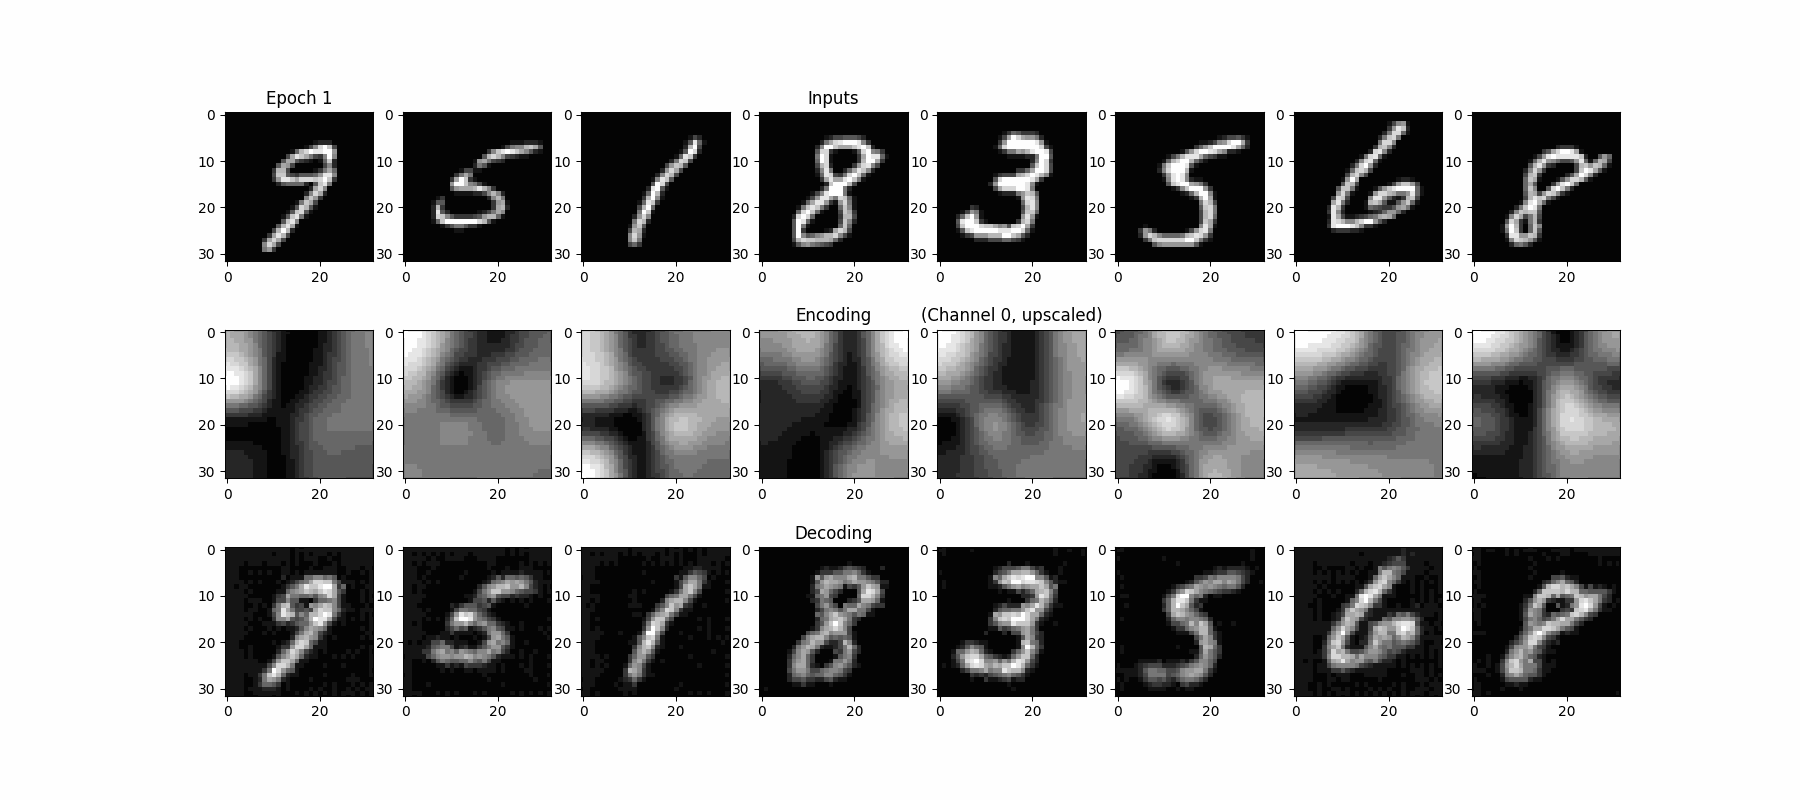

In [ ]:
imgviz_callback.save_gif('reconstructions')
IPython.display.Image(open('reconstructions.gif','rb').read())

### [Check-off]
- Does your reconstruction look at least somewhat reasonable? Anything interesting about it stand out to you? What are maybe some ways to improve it?
- What are the merits of using a cross-entropy loss function? How about a mean squared error loss function? Does combining the two make sense?

# Implement A Denoising Autoencoder

One of the nice uses for autoencoders is to denoise datasets. Since the autoencoders learn the most important attributes of data, they should logically discard unnecessary features of the data.

In this example, you can give this a shot by training an autoencoder to reverse some manual noising measures.

### Noise Functions

In order to test our autoencoder, we need to add some noise to our MNIST data points. The goal for the autoencoder is to learn the important underlying features (the numbers) of the data and to ignore the extra noise.

Implement the noise function below, which scales the values, shifts the values, and clips them to the [0, 1] space.

In [ ]:
def noiser(x, scale=(1,1), shift=(0,0), clip=(0,1), rand_fn=tf.random.uniform):
    '''
    Adds noise scale and offset and clips results.
    Default params lead to identify function with clipping to [0, 1]

    - scale   : positional args to rand_fn for multiplicative component
    - shift   : positional args to rand_fn for additive component
    - clip    : range of ourput values to clip to
    - rand_fn : random function to use (tf.random.<function>)

    when rand_fn = uniform : scale/shift are minval, maxval
    when rand_fn = normal  : scale/shift are mean, std dev
    '''
    assert len(shift) == len(scale) == len(clip) == 2, "range arguments must be pairs of len 2"

    noise_scale = rand_fn(tf.shape(x), *scale, dtype=tf.float32)
    noise_shift = rand_fn(tf.shape(x), *shift, dtype=tf.float32)

    ## TODO: Shift x by noise_shift and scale by noise_scale
    ##       Then, clip results to [0, 1] (hint: tf.clip_by_value)
    x = x * noise_scale + noise_shift
    x = tf.clip_by_value(x, *clip)

    return x

# some "unit tests"
x = [[0.3, 0.1], [0.2, 0   ]]
y = [[0.1, 1  ], [  0, 0.33]]
result_1 = noiser(x, shift=(-.3, .3))
result_2 = noiser(x, scale=(0, 2))
result_3 = noiser(y, shift=(-.3, .3))
result_4 = noiser(y, shift=(0, 2))

for res in [result_1, result_2, result_3, result_4]:
  assert res.shape == (2,2),            f"2x2 input produced a {res.shape} shape output"
  assert res.dtype == tf.float32,       f"Output of type {res.dtype}, not tf.float32"
  assert np.max(np.array(res)) <= 1.0,  f"Values should be clipped, but max is {np.max(np.array(res))}"
  assert np.min(np.array(res)) >= 0.0,  f"Values should be clipped, but min is {np.min(np.array(res))}"

print("Noise functions at least has ok output type!")

Noise functions at least has ok output type!


### Implement your architecture!

For this step, just do what you did earlier, but a little different. Most of it can be copy-and-pasted and the variable names should be changed as appropriate. One thing you will want to change, though, is the filtering scheme.

This time around, we'd still like to downsample quite a bit, but consider giving the bottleneck enough room to represent the data without too much blur. Play around with some values and ask the TA if you need help finding some good ones. Just consider how much info you're pushing through the bottleneck if you actually want a decent reconstruction!

In [ ]:
denoise_model = Autoencoder(
    encoder = tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), strides=2, **conv_kwargs),
        Conv2D(filters=64, kernel_size=(3, 3), strides=2, **conv_kwargs),
        Conv2D(filters=128, kernel_size=(3, 3), strides=2, **conv_kwargs),
    ], name='denoise_encoder'),
    decoder = tf.keras.Sequential([
        Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, **conv_kwargs),
        Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, **conv_kwargs),
        Conv2DTranspose(filters=1, kernel_size=(3,3), strides=2, **conv_kwargs)
    ], name='denoise_decoder')
)

denoise_model.build(input_shape = X0.shape)
initial_denoise_weights = denoise_model.get_weights()   ## Just so we can reset out autoencoder

denoise_model.summary()
denoise_model.encoder.summary()
denoise_model.decoder.summary()

Model: "autoencoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 denoise_encoder (Sequentia  (60000, 4, 4, 128)        92672     
 l)                                                              
                                                                 
 denoise_decoder (Sequentia  (60000, 32, 32, 1)        92545     
 l)                                                              
                                                                 
Total params: 185217 (723.50 KB)
Trainable params: 185217 (723.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "denoise_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (60000, 16, 16, 32)       320       
                                                      

### Visualizing The Training

Below is a slightly modified visualization function which will output just the inputs and outputs. Much simpler.

In [ ]:
class DenoiseVisualizer(ImageVisualizer):
    def __init__(self, model, sample_inputs, **kwargs):
        super().__init__(model, sample_inputs, **kwargs)

    ## The new result should just be the input and the prediction.
    ## Give some representation of what is what in the output image.

    def on_epoch_end(self, epoch, logs=None):
        encoding   = self.model.encoder(self.sample_inputs)
        prediction = self.model.decoder(encoding)  ## = self.model(self.sample_inputs)

        self.add_to_imgs(
            tf.concat([self.sample_inputs, prediction], axis=0),
            epoch = epoch
        )

    def add_to_imgs(self, outputs, epoch, nrows=2, ncols=8, figsize=(18, 8)):
        '''
        Plot the image samples in outputs in a pyplot figure and add the image
        to the 'imgs' list. Used to later generate a gif.
        '''
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        axs[0][0].set_title(f'Epoch {epoch+1}')
        axs[0][3].set_title('Inputs')
        axs[1][3].set_title('Outputs')
        for i, ax in enumerate(axs.reshape(-1)):
            out_numpy = np.squeeze(outputs[i].numpy(), -1)
            ax.imshow(out_numpy, cmap='gray')
        self.imgs += [self.fig2img(fig)]
        plt.close(fig)

### Training the denoising autoencoder!

Finally, we're ready to train this thing! To train it, we're just going to give it some noiseless inputs alongside some noisy inputs and train the model to output the noiseless counterparts. This stage might take a bit of time without a GPU, so we'd recommend switching your runtime for this part!

There's honestly not much to do here besides just seeing if your architecture holds up! Feel free to move your `denoise_model` initialization code into the cell for quick debugging, and make sure that your `mse_bce_loss` function is still accessible in this scope. If you notice that you're getting pretty poor results on visualization, consider talking to a TA about why that might be...

In [ ]:
noise_fn1 = lambda x: noiser(x, shift=(-.5, .5))
noise_fn2 = lambda x: noiser(x, scale=(0, 2))
noise_fn3 = lambda x: noiser(x, shift=(-.5, .5), scale=(0, 2))

denoise_viz_callback = DenoiseVisualizer(
    denoise_model,
    tf.concat([
        X0[-8:-6],
        noise_fn1(X0[-6:-4]),
        noise_fn2(X0[-4:-2]),
        noise_fn3(X0[-2:])
    ], axis=0)
)

denoise_model.set_weights(initial_denoise_weights)  ## Reset model weights

denoise_model.compile(
    optimizer   = tf.keras.optimizers.Adam(learning_rate=0.001),  ## Maybe change this?
    loss        = mse_bce_loss,                                   ## Is this still good?
    metrics     = [
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.BinaryCrossentropy()
    ]
)

inputs = tf.concat([
    X0[:5000],
    noise_fn1(X0[5000:7000]),
    noise_fn2(X0[7000:9000]),
], axis=0)

outputs = X0[:inputs.shape[0]]

denoise_model.fit(
    inputs, outputs,
    epochs     = 10,
    batch_size = 40,
    callbacks  = [denoise_viz_callback]
);

Epoch 1/10
225/225 [==============================] - 4s 8ms/step - loss: 0.1962 - mean_squared_error: 0.0300 - binary_crossentropy: 0.2077
Epoch 2/10
225/225 [==============================] - 2s 8ms/step - loss: 0.1227 - mean_squared_error: 0.0119 - binary_crossentropy: 0.1385
Epoch 3/10
225/225 [==============================] - 3s 11ms/step - loss: 0.1318 - mean_squared_error: 0.0133 - binary_crossentropy: 0.1482
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.1150 - mean_squared_error: 0.0099 - binary_crossentropy: 0.1314
Epoch 5/10
225/225 [==============================] - 2s 8ms/step - loss: 0.1148 - mean_squared_error: 0.0096 - binary_crossentropy: 0.1315
Epoch 6/10
225/225 [==============================] - 2s 9ms/step - loss: 0.1046 - mean_squared_error: 0.0071 - binary_crossentropy: 0.1218
Epoch 7/10
225/225 [==============================] - 2s 8ms/step - loss: 0.1066 - mean_squared_error: 0.0077 - binary_crossentropy: 0.1237
Epoch 8/10
225/225

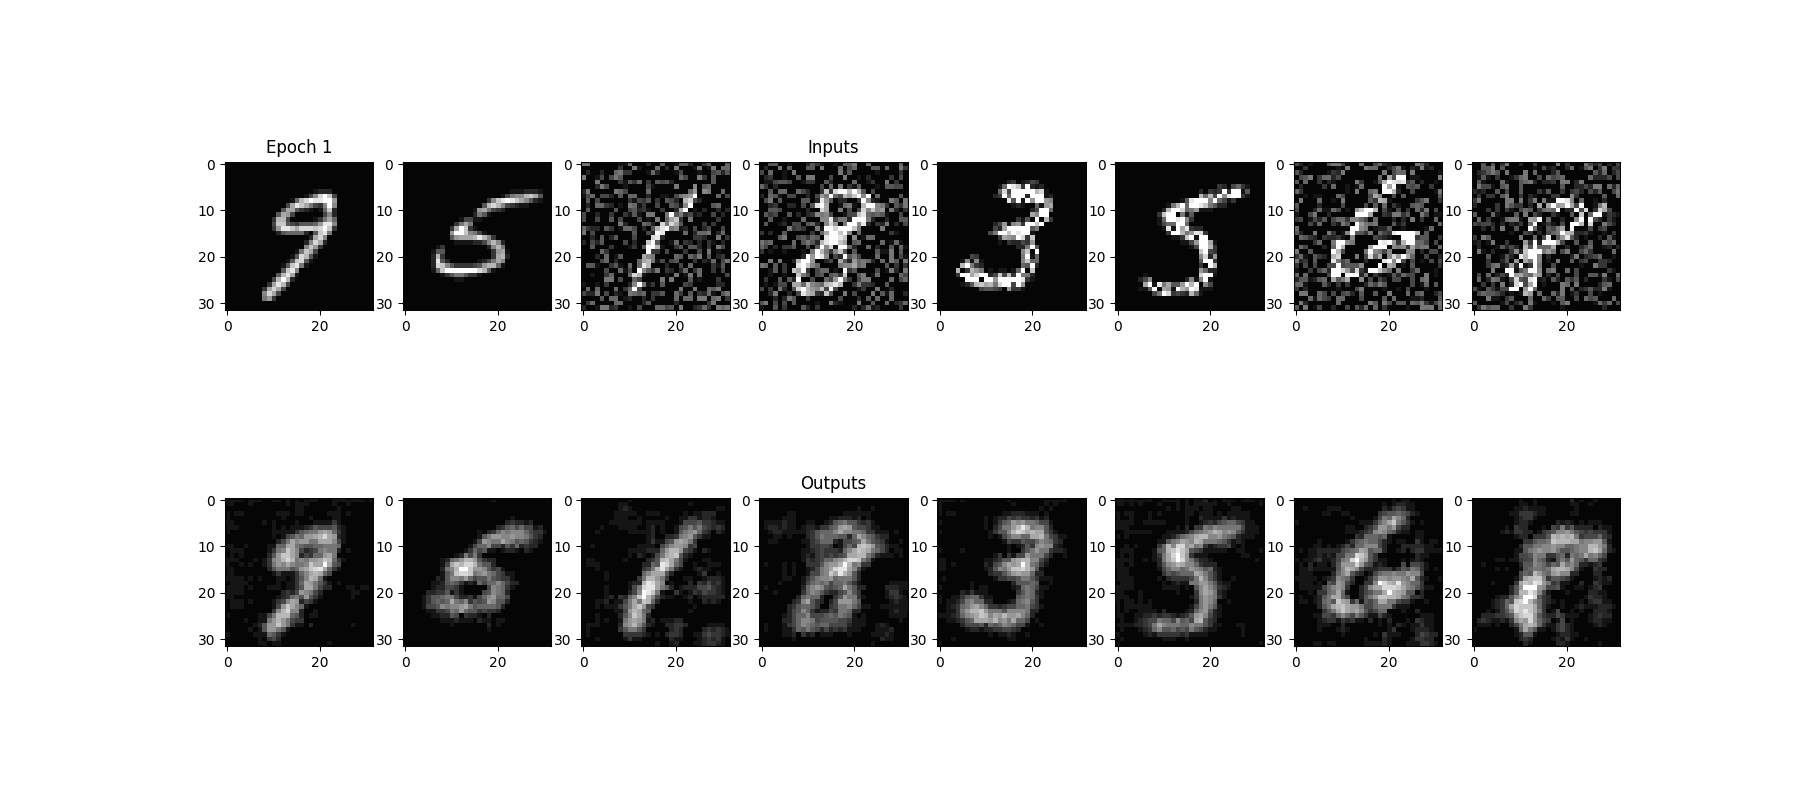

In [ ]:
denoise_viz_callback.save_gif('denoising')
IPython.display.Image(open('denoising.gif','rb').read())

## [Check-Off] Check in with your TA

Check to see if your denoiser works! If it works, you should see the autoencoder images remove noise from the original inputs. The top row for each epoch is the input image and the bottom is the autoencoded image.

Check out how the different noise functions are handled by the autoencoder.

## Visualizing the Data Representation

We can now visualize where MNIST data points are positioned in the lower dimensional vector space created by the autoencoder. Run the following cell to view a 2 dimensional projection of this vector space, where each color represents a different MNIST digit. Notice how even though the dimensionality of this space is much lower than the original (160 vs 784), relevant information about the digits is preserved.

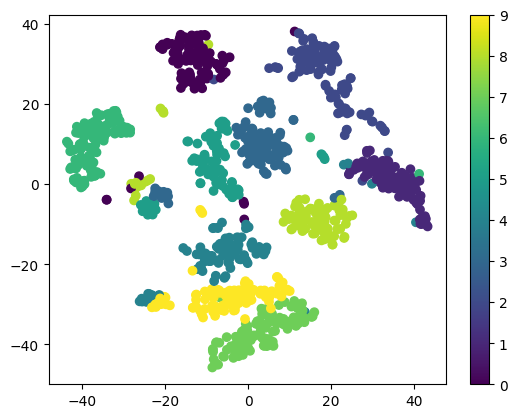

In [ ]:
from sklearn.manifold import TSNE

num_samples = 1000

z = denoise_model.encoder(X0[-num_samples:])
z = np.reshape(z, [num_samples, -1])

tsne = TSNE(n_components=2, learning_rate='auto', init='random')
transformed = tsne.fit_transform(z)
colors = L0[-num_samples:]
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors)
plt.colorbar()
plt.show()

## [Check-Off] Check in with your TA

Explain the significance of the different colored clusters and their locations on the graph.

# BONUS: Autocolorization?

Do you have too much time on your hands and also want to do something really neat? How about using auto-encoders to auto-colorize? Surprisingly enough, you have ***almost*** all the tools you need to do this with convolutional autoencoders!

Specifically, you can train an autoencoder to map from greyscale images to RGB images. Not too bad, right?

![canon-colorer-and-rgb](https://hotpot.ai/images/site/ai/colorizer/teaser.jpg)

Image from [hotpot.ai](hotpot.ai)

However, there are still a few issues:
- But our images are so blurry! We lose so much information from the encoding!
   - Maybe you could combine the prediction with the greyscale image somehow?
- But the 2D locality is preserved throughout the downsampling and upsampling, so some regions of the input image will only be able to impact some regions of the output image.
  - Maybe downsample to a 1x1 pixel with many filters, or maybe do a fully-connected embedding layer, or something?
- But we don't have a dataset :(
  - Why don't you try a subset of the famous [Cats and Dogs Dataset](https://keras.io/examples/vision/image_classification_from_scratch/)? Feel free to use the documentation for reference...
- But the images are all so big, and all different sizes.
  - Consider resizing all of the images to a consistent (and relatively small) representation. Also, consider using some lighter components (i.e. pooling).
- [Double-Bonus] But the colors can be whatever, right? Sometimes my colors look a bit... unreasonable.
  - So greyscale images are actually computed with a weighted function of red, green, and blue [as shown here](https://en.wikipedia.org/wiki/Grayscale). One easy one to think about is linear luminance: I know that the Python Image Library (PIL) uses $L = R * 299/1000 + G * 587/1000 + B * 114/1000$ (see Image.convert in [the docs](https://pillow.readthedocs.io/en/stable/reference/Image.html)). Maybe there is a way to derive the third channel as a function of the greyscale input and the other two channels, and this restrict the problem to a 2-channel prediction?...